
citations:
emojifier deep learning.ai

In [1]:
import pandas as pd
import math
import csv
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
dfDataDump = pd.read_csv('/home/archit/Desktop/ad_vs_organic/final_combined_organic_duration_titleastext.csv')

In [3]:
dfDataDump.drop(['Unnamed: 0','textData'], axis = 1, inplace = True)

In [4]:
dfDataDump = dfDataDump.sample(n = 40000)

In [5]:
dfDataDump.shape

(40000, 35)

In [6]:
dfLen = dfDataDump['cleanDescriptions'].apply(lambda x: len(x.split()))

In [7]:
np.max(dfLen)

107

In [8]:
dfLen.describe()

count    40000.000000
mean        56.238925
std         17.798384
min          2.000000
25%         44.000000
50%         59.000000
75%         71.000000
max        107.000000
Name: cleanDescriptions, dtype: float64

In [9]:
dfDataDump['cleanDescriptions'][0:5]

92120    صباح الورد حماية المستهلك رصدنا ارتفاع أسعار ا...
42998    priyanka chopra inauguration healthcare global...
44192    jagapathi babu fight scene crop jaanwar jaanwa...
7514     لحظة وصول موكب الرئيس االسيسي لإفتتاح مشروعا خ...
90132    فوضى المقدم فوزي عامر يشرح كيف القبض على الشبا...
Name: cleanDescriptions, dtype: object

Next we will set up our input dataset and define the function for model training

In [10]:
def input_dataset(dfData, views =0, categories =[], country= ['IN']):
    """manipulates input dataframe according to input parameters.
    Args:
        dfData: input dataset
        views: minimum number of views in dfData.Default = 0.
        categories: list of categories to be present in final dataset.Default is empty list(all categories)
        country: List of countries whose videos should be present in dataSet. Default is India.
    Returns:
        dataset to train model on
    """
    # slice dataset with viewCount larger than views
    dfData = dfData[dfData['viewCount'] >= views]
    # concat dfData according to categories
    categoryIds =(dfData['categoryId'].dropna().unique()).tolist()
    # create temporary df
    tempDf = pd.DataFrame(columns = ['vid', 'channelId', 'duration', 'licensedContent', 'definition',
       'dislikeCount', 'commentCount', 'favoriteCount', 'viewCount',
       'likeCount', 'relevantTopicIds', 'topicIds', 'topicCategories', 'title',
       'description', 'tags', 'categoryId', 'channelTitle', 'publishedAt',
       'Channel Title', 'Channel Description', 'Channel Publish date',
       ' Channel hiddenSubscriberCount', 'Channel viewCount',
       'Channel subscriberCount', 'Channel commentCount', 'Channel videoCount',
       'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories'])
    for categoryId in categoryIds:
        df = dfData[dfData['categoryId'] == categoryId]
        keys = []
        keys[0], keys[1] = tempDf['categoryId'][0], df['categoryId'][0]
        tempf = pd.concat([tempDf, df], ignore_index = True, keys = keys)
        
    # select dataframe according to categories
    if len(categories) != 0:
        dfData = tempDf.loc[categories]
    else:
        dfData = tempDf
    
    # choosing countries
    if len(country) != 0:
            dfData = dfData.loc[dfData['Channel country'] == country, ]
    else:
        dfData = dfData.loc[dfData['Channel country'] == 'IN']
        
    return dfData

In [ ]:
def preprocessing(dfData):
    """drops irrelevant features, merges adStats and previous video stats
    Args:
    dfData: input DataSet
    Return:
    merged DataSet
    """
    # drop irrelevant features
    dfData = dfData.drop(['licensedContent', 'relevantTopicIds', 'topicIds', 'topicCategories', 'channelTitle', 'Channel Title', 'Channel Description', ' Channel hiddenSubscriberCount', 'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories'], axis = 1)
    
    # load advertisement and previous stats dataset and clean
    dfAdStats = pd.read_csv('/home/archit/Desktop/ad_vs_organic/resultstats.csv').drop(['ch_id','Unnamed: 0'], axis =1)
    dfAdStats.rename(columns = {'video_id':'vid'}, inplace = True)
    dfPrevStats = pd.read_csv('/home/archit/Desktop/ad_vs_organic/previousVideoStats2.csv').drop(['Unnamed: 0'], axis =1)
    dfPrevStats.rename(columns = {'Id':'vid'}, inplace = True)

    # merge DataSet
    dfMergedData = dfData.merge(dfPrevStats, on = 'vid', how = 'left')
    dfMergedData = dfMergedData.merge(dfAdStats, on = 'vid', how = 'left')
    return dfMergedData

In [12]:
def preprocessing2(dfData):
    """drops irrelevant features, merges adStats and previous video stats
    Args:
    dfData: input DataSet
    Return:
    merged DataSet
    """
    # drop irrelevant features
    dfData = dfData.drop(['licensedContent', 'relevantTopicIds', 'topicIds', 'topicCategories', 'channelTitle', 'Channel Title', 'Channel Description', ' Channel hiddenSubscriberCount', 'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories'], axis = 1)
    
    # load advertisement and previous stats dataset and clean
    dfAdStats = pd.read_csv('/home/archit/Desktop/ad_vs_organic/resultstats.csv').drop(['ch_id','Unnamed: 0'], axis =1)
    dfAdStats.rename(columns = {'video_id':'vid'}, inplace = True)
    dfPrevStats = pd.read_csv('/home/archit/Desktop/ad_vs_organic/previousVideoStats2.csv').drop(['Unnamed: 0'], axis =1)
    dfPrevStats.rename(columns = {'Id':'vid'}, inplace = True)

    # merge DataSet
    dfMergedData = dfData.merge(dfPrevStats, on = 'vid', how = 'left')
    dfMergedData = dfMergedData.merge(dfAdStats, on = 'vid', how = 'left')
    
    dfMergedData['viewCount'] = dfMergedData['ad%'] * dfMergedData['viewCount']
    return dfMergedData

In [13]:
def feature_engineer(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount', 'categoryId'],axis =1)
    
    
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['PrevCommentCount'] = dfData['PrevCommentCount'].fillna(0)
    dfData['PrevDislikeCount'] = dfData['PrevDislikeCount'].fillna(0)
    dfData['PrevLikeCount'] = dfData['PrevLikeCount'].fillna(0)
    dfData['PrevViewCount'] = dfData['PrevViewCount'].fillna(0)   
    dfData['duration'] = dfData['duration'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['Channel subscriberCount'] = dfData['Channel subscriberCount'].fillna(0)
    dfData['Definition'] = dfData['definition'].apply(lambda x: 1 if x=='hd' else 0)
    dfData = dfData.drop(['title','description','publishedAt','Channel viewCount','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [14]:
dfData = preprocessing(dfDataDump)
dfData.columns

Index(['vid', 'channelId', 'duration', 'definition', 'dislikeCount',
       'commentCount', 'favoriteCount', 'viewCount', 'likeCount', 'title',
       'description', 'tags', 'categoryId', 'publishedAt',
       'Channel Publish date', 'Channel viewCount', 'Channel subscriberCount',
       'Channel commentCount', 'Channel videoCount', 'cleanDescriptions',
       'PrevCommentCount', 'PrevDislikeCount', 'PrevLikeCount',
       'PrevPublishedAt', 'PrevViewCount', 'PrevTitle', 'ad%'],
      dtype='object')

In [15]:
df = feature_engineer(dfData)

In [16]:
np.max(df['cleanDescriptions'])

'화염방사기로 불태워 죽이는 파이어브레이크 게임플레이 게임플레이 콜오브듀티 블랙옵스 알로직 알로직 arelogic 블랙옵스 블랙옵스 콜오브듀티 블랙아우스 블랙옵스 플레이 블랙옵스 파이어브레이크 블랙옵스 스코어스트릭 블랙옵스 스페셜리스트 블랙옵스 블랙옵스 플레이 블랙옵스 오픈베타 블랙옵스 멀티플레이 블랙옵스 블랙옵스 전문가 블랙옵스 블랙옵스 블랙옵스 클래스 블랙옵스 블랙옵스 블랙옵스 게임플레이 블랙옵스 파이어브레이크 플레이 블랙옵스 파이어브레이크 블랙옵스 파이어브레이크'

In [17]:
df.columns

Index(['vid', 'duration', 'definition', 'dislikeCount', 'commentCount',
       'viewCount', 'likeCount', 'Channel subscriberCount',
       'Channel videoCount', 'cleanDescriptions', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevViewCount', 'PublishedYear',
       'ChannelAge', 'channelViewCount', 'LikeDislikeRatio', 'Definition'],
      dtype='object')

In [21]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.75, test_size = 0.25)

/home/archit/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Now we will use use genism library implementation of word2vec and parse each sentence to get its vector representation

In [18]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

/home/archit/anaconda3/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


As Phrases use list of list of words as input

In [19]:
sent = [description.split() for description in df['cleanDescriptions']]

Create relevant phrases from a list of sentences

In [20]:
phrases = Phrases(sent, min_count=10, progress_per=10000)

Goal of the Phraser() is to cut down the memory consumptionn of the Phrases()

In [21]:
bigram = Phraser(phrases)

Transform the corpus based on the bigrams detected

In [22]:
sentences = bigram[sent]

In [23]:
import multiprocessing
cores = multiprocessing.cpu_count()

#### Training the model

In [24]:
w2v_model = Word2Vec(min_count = 1,
                     window = 2,
                     size = 256,
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=10,
                     workers=cores-1)

Building the vocabulory.Word2Vec requires us to build the vocabulory table.

In [25]:
w2v_model.build_vocab(sentences, progress_per=10000)

Training word2vec

In [26]:
import time
t = time.time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to train the model: 6.36 mins


In [27]:
def sentence_to_avg(sentence, word_to_vec):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the word2vec representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec -- dictionary mapping every word in a vocabulary into its 256-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (256,)
    """
    
    # Split sentence into list of lower case words (≈ 1 line)
    words = [i.lower() for i in sentence.split()]

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros((256,))
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        try:
            avg += word_to_vec[w]
        except:
            pass
        
    avg = avg / len(words)
        
    return avg

In [28]:
embedding = []
for sentence in list(df['cleanDescriptions']):
    embedding.append(sentence_to_avg(sentence, w2v_model))

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [31]:
embedding = []
for i in range(0, 256):
    embedding.append([])
for sentence in list(df['cleanDescriptions']):
    result = list(sentence_to_avg(sentence, w2v_model))
    for j in range(0, 256):
        embedding[j].append(result[j])

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [35]:
for i in range(0, 256):
    df[str(i)] = embedding[i]

Training data

In [ ]:
df = feature_engineer(dfTrainingSet)


In [46]:
X, y = df.drop('viewCount',axis = 1) , np.log(df['viewCount'])
X.columns

Index(['vid', 'duration', 'definition', 'dislikeCount', 'commentCount',
       'likeCount', 'Channel subscriberCount', 'Channel videoCount',
       'cleanDescriptions', 'PrevCommentCount',
       ...
       '246', '247', '248', '249', '250', '251', '252', '253', '254', '255'],
      dtype='object', length=275)

In [47]:
X.drop(['definition', 'cleanDescriptions'], axis = 1, inplace=True)

In [48]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.75, test_size = 0.25)

### Scaling data for applying before to neural nets

In [49]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [50]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

In [51]:
def normalize_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  examples_dataframe["duration"] = log_normalize(examples_dataframe["duration"])
  examples_dataframe["dislikeCount"] = log_normalize(examples_dataframe["dislikeCount"])
  examples_dataframe["commentCount"] = log_normalize(examples_dataframe["commentCount"])
  examples_dataframe["likeCount"] = log_normalize(examples_dataframe["likeCount"])
  examples_dataframe["Channel subscriberCount"] = linear_scale(examples_dataframe["Channel subscriberCount"])
  examples_dataframe["Channel videoCount"] = linear_scale(examples_dataframe["Channel videoCount"])
  examples_dataframe["PrevCommentCount"] = log_normalize(examples_dataframe["PrevCommentCount"])
  examples_dataframe["PrevDislikeCount"] = log_normalize(examples_dataframe["PrevDislikeCount"])
  examples_dataframe["PrevViewCount"] = log_normalize(examples_dataframe["PrevViewCount"])
  examples_dataframe["LikeDislikeRatio"] = linear_scale(examples_dataframe["LikeDislikeRatio"])
  examples_dataframe["channelViewCount"] = log_normalize(examples_dataframe["channelViewCount"])

    
  return examples_dataframe

normalized_dataframe = normalize_scale(train_X)

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

### Modeling

In [53]:
train_X_id, train_X = train_X.vid, train_X.drop('vid', axis = 1)
test_X_id, test_X = test_X.vid, test_X.drop('vid', axis = 1)

reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

-0.7888841316359072

In [54]:
pred = reg.predict(test_X)

In [55]:
size = test_y.shape[0]
test_yL = test_y.tolist()
predL = pred.tolist()
exActView = []
exPredView = []
diff = []
sqErr = []
mape={}
for i in range(0, size):
    exActView.append(math.exp(test_yL[i]))
    exPredView.append(math.exp(predL[i]))
    diff.append(exActView[i] - exPredView[i])
    sqErr.append(math.pow(diff[i], 2))
rmse = math.sqrt(sum(sqErr) /size)/ (test_y.max() - test_y.min())
dfEval = pd.DataFrame({'Id':test_X_id, 'Actual' : exActView, 'Pred': exPredView, 'Diff': diff})
dfEval.head()

,Actual,Diff,Id,Pred
13635,1661.0,-5.591534e+03,yqA7Y6mgzJE,7.252534e+03
27341,9558.0,-1.920659e+07,wTNQ6erYNnI,1.921615e+07
9491,49635.0,-2.338414e+07,Rx6YQC9TXe8,2.343378e+07
4066,1262.0,-3.263442e+02,pxay1B6QxvA,1.588344e+03
33324,759.0,-9.198338e+02,QxbJLcsE6uc,1.678834e+03


In [56]:
print("Rmse of the regressormodel is:" + str(rmse))

Rmse of the regressormodel is:599196.5262339924


In [26]:
import numpy as np
np.random.seed(0)
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, CuDNNLSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint

np.random.seed(1)

In [28]:
def PREDICT_USING_TEXT_V2(input_shape):
    """
    Function creating the PREDICT_USING_TEXT-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    # Define padded_description as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    padded_descriptions = Input(input_shape, dtype='int32', name = 'main_input')
    
    # Propagate padded_descriptions through embedding layer, you get back the embeddings
    embeddings = Embedding(output_dim=20, input_dim=vocabSize, input_length=max_length)(padded_descriptions)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    lstm_out = LSTM(128, return_sequences=False)(X)
    
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    auxiliary_output = Dense(5)(X)
    # Add a softmax activation
    auxiliary_output = Activation('softmax')(auxiliary_output)
    
    
    # Here we insert the auxiliary loss, allowing the LSTM and Embedding layer to be trained smoothly even though the
    # main loss will be much higher in the model
    
    # at this time we feed our auxillary input data by concatenating it with the Lstm output
    auxiliary_input = Input(shape = (15,), name = 'auxiliary_input')
    x = concatenate([lstm_out, auxiliary_input])
    
    # stack a deep densely connected network on top
    x = Dense(256, activation='tanh')(x)
    x = Dense(256, activation='linear')(x)
    
    x = LeakyReLU(alpha=0.001)(x)
    x = Dense(256, activation='tanh')(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='linear')(x)

    main_output = Dense(1, name = 'main_output')(x)
    
    
    # define model with two inputs and two outputs
    model = Model(inputs=[padded_descriptions, auxiliary_input], outputs= main_output)
    
    ### END CODE HERE ###
    
    return model

In [29]:
model = PREDICT_USING_TEXT_V2((max_length,))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 650)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 650, 20)      3541000     main_input[0][0]                 
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 650, 128)     76288       embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)  

In [30]:
# optimizer for regression stacking
adam = Adam(lr=0.002, decay = 0.00001)

In [31]:
model.compile(loss='mean_squared_error', optimizer=adam)

In [32]:
X.drop(['definition', 'vid', 'cleanDescriptions'], axis=1, inplace=True)

In [33]:
X.columns

Index(['duration', 'dislikeCount', 'commentCount', 'likeCount',
       'Channel subscriberCount', 'Channel videoCount', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevViewCount', 'PublishedYear',
       'ChannelAge', 'channelViewCount', 'LikeDislikeRatio', 'Definition'],
      dtype='object')

In [34]:
#print((padded_descriptions[0:5]))
X.head()

,duration,dislikeCount,commentCount,likeCount,Channel subscriberCount,Channel videoCount,PrevCommentCount,PrevDislikeCount,PrevLikeCount,PrevViewCount,PublishedYear,ChannelAge,channelViewCount,LikeDislikeRatio,Definition
3,607.0,17.0,21.0,130.0,16085.0,118.0,21.0,17.0,130.0,41380.0,2016,2016,15.983476,0.884354,1
4,552.0,13.0,18.0,129.0,16085.0,118.0,18.0,13.0,129.0,60971.0,2016,2016,15.983476,0.908451,1
9,520.0,12.0,28.0,109.0,16085.0,118.0,28.0,12.0,109.0,33071.0,2016,2016,15.983476,0.900826,1
10,756.0,42.0,28.0,187.0,16085.0,118.0,28.0,42.0,187.0,92608.0,2016,2016,15.983476,0.816594,1
11,592.0,20.0,18.0,115.0,16085.0,118.0,18.0,20.0,115.0,58258.0,2016,2016,15.983476,0.851852,1


In [ ]:
resume_model = load_model("/home/archit/Music/organicViews/weights-improvement-01-25597147126.87.hdf5")
filepath="/home/archit/Desktop/ad_vs_organic/LStM/organicViews/weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
resume_model.fit({'main_input':padded_descriptions, 'auxiliary_input': X}, {'main_output': y}, epochs = 50, batch_size = 32, callbacks=callbacks_list, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
40569/40569 [==============================] - 4901s 121ms/step - loss: 63820552472.5026

Epoch 00001: loss improved from inf to 63820552472.50265, saving model to /home/archit/Desktop/ad_vs_organic/LStM/organicViews/weights-improvement-01-63820552472.50.hdf5
Epoch 2/50
40569/40569 [==============================] - 5249s 129ms/step - loss: 60696455905.5405

Epoch 00002: loss improved from 63820552472.50265 to 60696455905.54049, saving model to /home/archit/Desktop/ad_vs_organic/LStM/organicViews/weights-improvement-02-60696455905.54.hdf5
Epoch 3/50
24192/40569 [================>.............] - ETA: 36:25 - loss: 62566541587.9788

In [ ]:
model.load_weights("/home/archit/Desktop/ad_vs_organic/LStM/weights-improvement-01-3.68.hdf5")

In [ ]:
dfVal = feature_engineer(dfValidationData)

In [60]:
dfValidationData.columns

Index(['vid', 'channelId', 'duration', 'definition', 'dislikeCount',
       'commentCount', 'favoriteCount', 'viewCount', 'likeCount', 'title',
       'description', 'tags', 'categoryId', 'publishedAt',
       'Channel Publish date', 'Channel viewCount', 'Channel subscriberCount',
       'Channel commentCount', 'Channel videoCount', 'Lang',
       'cleanDescriptions', 'PrevCommentCount', 'PrevDislikeCount',
       'PrevLikeCount', 'PrevPublishedAt', 'PrevViewCount', 'PrevTitle',
       'ad%'],
      dtype='object')

In [48]:
X_, y = dfVal.drop('viewCount',axis = 1) , np.log(dfVal['viewCount'])


In [49]:
descriptions2 = []
videos = list(X_.vid)
for vid in videos:
    Dict = dfDataDump.loc[dfDataDump['vid'] == vid, 'cleanDescriptions'].to_dict()
    descriptions2.append(getVal(Dict))

In [50]:
descriptions2 = pd.Series(descriptions2)

In [51]:
X_.drop(['definition', 'vid'], axis=1, inplace=True)

In [53]:
X_train_indices2 = sentences_to_indices(descriptions2.values, word_to_index, 703)

In [55]:
result = resume_model.predict({'main_input':X_train_indices2, 'auxiliary_input': X_})

In [58]:
result[0:5]

array([[7.1692953],
       [7.089959 ],
       [7.320867 ],
       [7.1694145],
       [6.950097 ]], dtype=float32)

In [63]:
# function exponentiates values in test_y and pred and
# than calulated rmse of actual views
import math
size = y.shape[0]
test_yL = dfValidationData['viewCount'].tolist()
predL = result.tolist()
exActView = []
exPredView = []
diff = []
sqErr = []
for i in range(0, size):
    exActView.append((test_yL[i]))
    exPredView.append(math.exp(predL[i][0]))
    diff.append(exActView[i] - exPredView[i])
    sqErr.append(math.pow(diff[i], 2))

rmse = math.sqrt(sum(sqErr) /size)/(max(exActView) - min(exActView))
dfEval = pd.DataFrame({'vid': dfValidationData['vid'], 'Actual' : exActView, 'Pred': exPredView, 'Diff': diff, 'ad%':dfValidationData['ad%']})
dfEval.head()

,Actual,Diff,Pred,ad%,vid
5,394.0,-904.928939,1298.928939,33.421053,jCnNgHTdbYY
6,254.0,-945.858779,1199.858779,0.406504,iR_gXXK0Q_Q
11,4478.0,2966.486022,1511.513978,70.752984,fIPFc687ink
12,2233.0,933.916207,1299.083793,0.136488,8bLDlaRfp9c
20,54352.0,53308.748994,1043.251006,0.001860,gYd1wqGqZnk


In [64]:
dfEval['Predicted Ad %'] = (dfEval['Diff'])/dfEval['Actual']*100
dfEval.head()

,Actual,Diff,Pred,ad%,vid,Predicted Ad %
5,394.0,-904.928939,1298.928939,33.421053,jCnNgHTdbYY,-229.677396
6,254.0,-945.858779,1199.858779,0.406504,iR_gXXK0Q_Q,-372.385346
11,4478.0,2966.486022,1511.513978,70.752984,fIPFc687ink,66.245780
12,2233.0,933.916207,1299.083793,0.136488,8bLDlaRfp9c,41.823386
20,54352.0,53308.748994,1043.251006,0.001860,gYd1wqGqZnk,98.080566


In [65]:
dfEval[dfEval['Predicted Ad %']<0]=0
dfEval.head()

,Actual,Diff,Pred,ad%,vid,Predicted Ad %
5,0.0,0.000000,0.000000,0.000000,0,0.000000
6,0.0,0.000000,0.000000,0.000000,0,0.000000
11,4478.0,2966.486022,1511.513978,70.752984,fIPFc687ink,66.245780
12,2233.0,933.916207,1299.083793,0.136488,8bLDlaRfp9c,41.823386
20,54352.0,53308.748994,1043.251006,0.001860,gYd1wqGqZnk,98.080566


In [ ]:
# save the model
from keras.models import load_model
model.save('/home/archit/Desktop/ad vs organic/ad_vs_organic_keras_model.h5')

Now we will use standard metrics and evaluate our result

In [66]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [67]:
r2_score(dfEval['ad%'],dfEval['Predicted Ad %'])

-164.78591121628605

In [70]:
np.sqrt(mean_squared_error(dfEval['ad%'],dfEval['Predicted Ad %']))

84.83562740807251

In [72]:
mean_absolute_error(dfEval['ad%'],dfEval['Predicted Ad %'])

79.3856331210703

In [ ]:
bins =int( (dfEval['Diff'].max() - dfEval['Diff'].min())/5)
gh = plt.hist(dfEval['Diff'], bins = bins)
freq, error = gh[0], gh[1]
plt.ylabel('Number of videos')
plt.xlabel('error')
plt.title('Frequiency table of diff in ad%')
plt.show()

In [ ]:
freq = freq.astype('int64')
dfErr = pd.DataFrame()
dfErr['Error'] = pd.Series(error)
dfErr['Frequency'] = pd.Series(freq)
dfErr['Frequency Percentage'] = dfErr['Frequency']/ dfErr['Frequency'].sum() * 100
dfErr

Now we will look for videos with error in prediction > 30 and figure out why.

In [ ]:
dfErr[np.abs(dfErr['Error'])>30]

In [29]:
# Loading ad stats dataset
dfAdStats = pd.read_csv('/home/archit/Desktop/ad vs organic/resultstats.csv')
dfAdStats2 = dfAdStats.drop(['ch_id','Unnamed: 0'], axis =1)
dfAdStats2.rename(columns = {'video_id':'vid'}, inplace = True)
dfAdStats2.shape

(246184, 2)

In [41]:
# Loading perv stats dataset
dfPrevStats = pd.read_csv('/home/archit/Desktop/ad vs organic/previousVideoStats2.csv')
dfPrevStats = dfPrevStats.drop(['Unnamed: 0'], axis =1)
dfPrevStats.rename(columns = {'Id':'vid'}, inplace = True)

dfPrevStats.head()

,PrevCommentCount,PrevDislikeCount,PrevLikeCount,PrevPublishedAt,PrevViewCount,PrevTitle,vid
0,9.0,5.0,112.0,2016-08-25T03:48:52.000Z,21007.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 13 - Hà...,NaN
1,7.0,6.0,77.0,2016-11-15T06:59:55.000Z,19326.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 14 - Kh...,LPqCSwCNI5w
2,28.0,12.0,109.0,2016-11-15T07:01:46.000Z,33071.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 17 - Gi...,0LGl5jbnrlU
3,8.0,9.0,84.0,2016-11-15T07:01:55.000Z,29516.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 18 - C...,jFFSYwdku9M
4,12.0,18.0,145.0,2016-11-15T07:02:03.000Z,49653.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 19 - Ăn...,HvFNGb-nrRU


### Merging Dataset

In [42]:
dfMergedData = dfData2.merge(dfPrevStats, on = 'vid', how = 'left')
dfMergedData = dfMergedData.merge(dfAdStats2, on = 'vid', how = 'left')

In [43]:
dfMergedData.columns

Index(['Unnamed: 0', 'vid', 'channelId', 'duration', 'dislikeCount',
       'commentCount', 'favoriteCount', 'viewCount', 'likeCount', 'title',
       'description', 'tags', 'categoryId', 'publishedAt',
       'Channel Publish date', 'Channel viewCount', 'Channel subscriberCount',
       'Channel commentCount', 'Channel videoCount', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevPublishedAt', 'PrevViewCount',
       'PrevTitle', 'ad%'],
      dtype='object')

In [44]:
dfMergedData.to_csv("/home/archit/Desktop/ad vs organic/merged_data_ad_vs_org.csv")

In [45]:
dfMergedData = pd.read_csv('/home/archit/Desktop/ad vs organic/merged_data_ad_vs_org.csv')

### Picking up traininig set and validation set

In [46]:
dfTrainingSet = dfMergedData.loc[dfMergedData['ad%'] == 0,]
dfTrainingSet.shape

(112873, 27)

In [47]:
dfValidationSet = dfMergedData.loc[dfMergedData['ad%']>0, ]

dfValidationSet.shape

(8003, 27)

dfTrainingSet.to_csv("/home/archit/Desktop/ad vs organic/training_data_ad_vs_org3.csv")


In [48]:
dfValidationSet['orgViews'] = dfValidationSet['viewCount']*(100-dfValidationSet['ad%'])

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
dfValidationSet.drop('viewCount', axis=1, inplace= True)
dfValidationSet.rename(columns = {'orgViews':'viewCount'}, inplace = True)

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/archit/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [23]:
dfTrainingSet = pd.concat([dfTrainingSet, dfValidationSet], ignore_index = True)

In [24]:
dfTrainingSet.shape

(36515, 26)

In [25]:
dfValidationSet.to_csv('/home/archit/Desktop/ad vs organic/validation_data_ad_vs_org3.csv')

### Feature engineering


In [50]:
def feature_engineer(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount', 'categoryId'],axis =1)
    
    
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['PrevCommentCount'] = dfData['PrevCommentCount'].fillna(0)
    dfData['PrevDislikeCount'] = dfData['PrevDislikeCount'].fillna(0)
    dfData['PrevLikeCount'] = dfData['PrevLikeCount'].fillna(0)
    dfData['PrevViewCount'] = dfData['PrevViewCount'].fillna(0)   
    dfData['duration'] = dfData['duration'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['Channel subscriberCount'] = dfData['Channel subscriberCount'].fillna(0)
    dfData = dfData.drop(['title','description','publishedAt','Channel viewCount','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [51]:
def feature_engineer2(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount'],axis =1)
    
    dfData = dfData.dropna()
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData = dfData.drop(['title','description','publishedAt','','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [52]:
df = feature_engineer(dfTrainingSet)
#df.to_csv('/home/archit/Desktop/ad vs organic/trainSet2.csv')

In [61]:
X, y = df.drop('viewCount',axis = 1) , np.log(df['viewCount'])
X = X.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
X.shape

ValueError: labels ['Unnamed: 0' 'Unnamed: 0.1'] not contained in axis

In [69]:
X.columns

Index(['vid', 'duration', 'dislikeCount', 'commentCount', 'likeCount',
       'Channel subscriberCount', 'Channel videoCount', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevViewCount', 'PublishedYear',
       'ChannelAge', 'channelViewCount', 'LikeDislikeRatio'],
      dtype='object')

In [55]:
#X.to_csv('/home/archit/Desktop/ad vs organic/trainSET.csv')

### Modeling

In [70]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
#from xgboost import XGBClassifier, XGBRegressor

In [71]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.75, test_size = 0.25)

train_X_id, train_X = train_X.vid, train_X.drop('vid', axis = 1)
test_X_id, test_X = test_X.vid, test_X.drop('vid', axis = 1)

reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

import pickle
pickle.dump(reg, open("Gbr005.pickle.dat", "wb"))

In [72]:
pred = reg.predict(test_X)

In [73]:
size = test_y.shape[0]
test_yL = test_y.tolist()
predL = pred.tolist()
exActView = []
exPredView = []
diff = []
sqErr = []
mape={}
for i in range(0, size):
    exActView.append(math.exp(test_yL[i]))
    exPredView.append(math.exp(predL[i]))
    diff.append(exActView[i] - exPredView[i])
    sqErr.append(math.pow(diff[i], 2))
rmse = math.sqrt(sum(sqErr) /size)/ (test_y.max() - test_y.min())
dfEval = pd.DataFrame({'Id':test_X_id, 'Actual' : exActView, 'Pred': exPredView, 'Diff': diff})
dfEval.head()

,Actual,Diff,Id,Pred
44138,411.0,101.860164,lhpiPhfw8m8,309.139836
31600,881.0,-105.292991,2DEfSW3e3Hg,986.292991
27166,533.0,-201.823546,ZlBuyx8qz64,734.823546
67319,3926.0,1070.292623,fM38i1eHr98,2855.707377
42187,385.0,200.500859,_R4DWeJhz7Y,184.499141


In [74]:
print("Rmse of the regressormodel is:" + str(rmse))

Rmse of the regressormodel is:2387.4454790550158


In [75]:
1011.0650776175543/dfEval['Actual'].mean()

0.04029664809978987

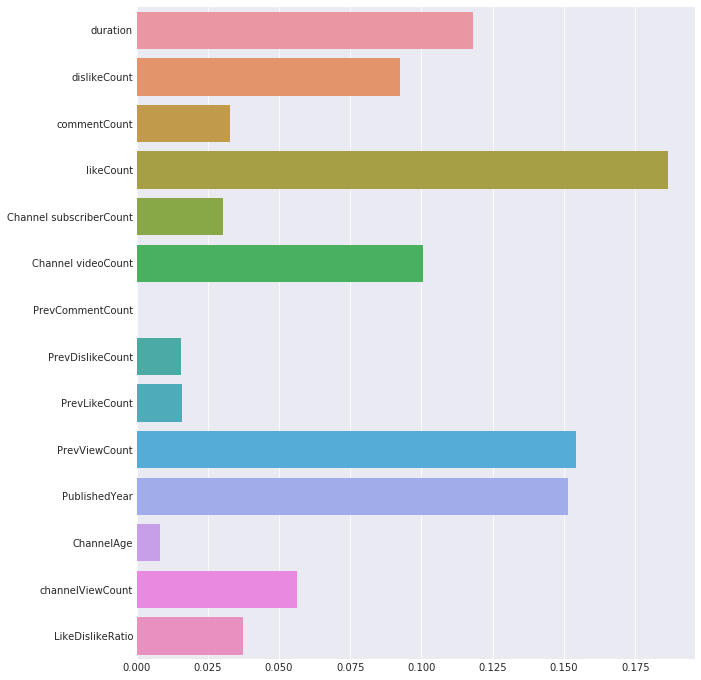

In [76]:
X = X.drop('vid', axis = 1)
sns.set_style('darkgrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

### Modeling on validation set

In [91]:
df = feature_engineer(dfValidationSet)